In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('cleaned_data.csv')

# Удаление ненужных столбцов
data = data.drop('Unnamed: 0', axis=1)

# Создание бинарных целевых переменных на основе медианных значений
median_si = data['SI'].median()

data['SI_above_median'] = (data['SI'] > median_si).astype(int)

# Разделение на признаки и целевые переменные
features = data.drop(['IC50, mM', 'CC50, mM', 'SI', 
                     'SI_above_median'], axis=1)
targets = data[['SI_above_median']]

# Масштабирование признаков
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, targets, test_size=0.2, random_state=42)

# Функция для обучения и оценки моделей
def train_and_evaluate_models(X_train, X_test, y_train, y_test, target_name):
    print(f"\n=== Модели для классификации: {target_name} ===")
    
    # Инициализация моделей
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }
    
    best_model = None
    best_score = 0
    results = {}
    
    for name, model in models.items():
        print(f"\nОбучение модели: {name}")
        
        # Обучение модели
        model.fit(X_train, y_train[target_name])
        
        # Предсказания
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Оценка качества
        print(classification_report(y_test[target_name], y_pred))
        roc_auc = roc_auc_score(y_test[target_name], y_proba)
        print(f"ROC-AUC: {roc_auc:.4f}")
        
        # Сохранение результатов
        results[name] = {
            'classification_report': classification_report(y_test[target_name], y_pred, output_dict=True),
            'roc_auc': roc_auc
        }
        
        # Проверка на лучшую модель
        if roc_auc > best_score:
            best_score = roc_auc
            best_model = name
    
    print(f"\nЛучшая модель для {target_name}: {best_model} с ROC-AUC = {best_score:.4f}")
    return results, best_model

# Обучение моделей для каждой целевой переменной
si_results, si_best = train_and_evaluate_models(X_train, X_test, y_train, y_test, 'SI_above_median')

# Оптимизация гиперпараметров для лучших моделей
def optimize_best_model(model_name, X_train, y_train):
    if model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
        model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
        model = XGBClassifier(random_state=42, eval_metric='logloss')
    elif model_name == 'LightGBM':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 50],
            'max_depth': [-1, 5]
        }
        model = LGBMClassifier(random_state=42)
    else:
        return None
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"\nЛучшие параметры для {model_name}:")
    print(grid_search.best_params_)
    print(f"Лучший ROC-AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Оптимизация для каждой задачи
best_si_model = optimize_best_model(si_best, X_train, y_train['SI_above_median'])




=== Модели для классификации: SI_above_median ===

Обучение модели: Logistic Regression
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       108
           1       0.63      0.62      0.63        93

    accuracy                           0.66       201
   macro avg       0.65      0.65      0.65       201
weighted avg       0.66      0.66      0.66       201

ROC-AUC: 0.6737

Обучение модели: Gradient Boosting
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       108
           1       0.63      0.65      0.64        93

    accuracy                           0.66       201
   macro avg       0.66      0.66      0.66       201
weighted avg       0.66      0.66      0.66       201

ROC-AUC: 0.7106

Обучение модели: XGBoost
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       108
           1       0.60      0.62      0.61        93



Анализ медианного значения SI:
Медианное значение SI: 3.8462
Количество соединений с SI > медианы: 500 из 1001
Доля соединений с SI > медианы: 49.95%



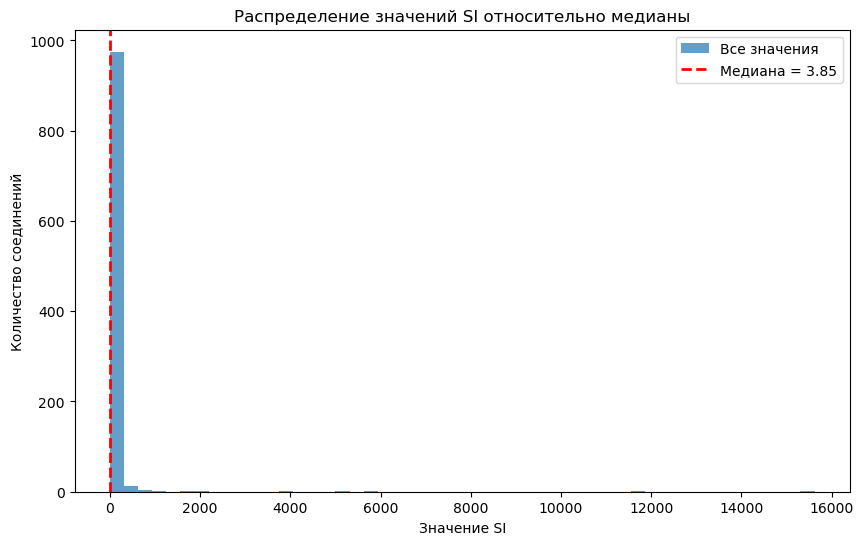

In [9]:
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("Анализ медианного значения SI:")
print(f"Медианное значение SI: {median_si:.4f}")
print(f"Количество соединений с SI > медианы: {data['SI_above_median'].sum()} из {len(data)}")
print(f"Доля соединений с SI > медианы: {data['SI_above_median'].mean():.2%}")
print("="*50 + "\n")


plt.figure(figsize=(10, 6))
plt.hist(data['SI'], bins=50, alpha=0.7, label='Все значения')
plt.axvline(median_si, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_si:.2f}')
plt.title('Распределение значений SI относительно медианы')
plt.xlabel('Значение SI')
plt.ylabel('Количество соединений')
plt.legend()
plt.show()


Анализ значений SI относительно порога 8:
Медианное значение SI: 3.8462
Количество соединений с SI > 8: 357 из 1001
Доля соединений с SI > 8: 35.66%



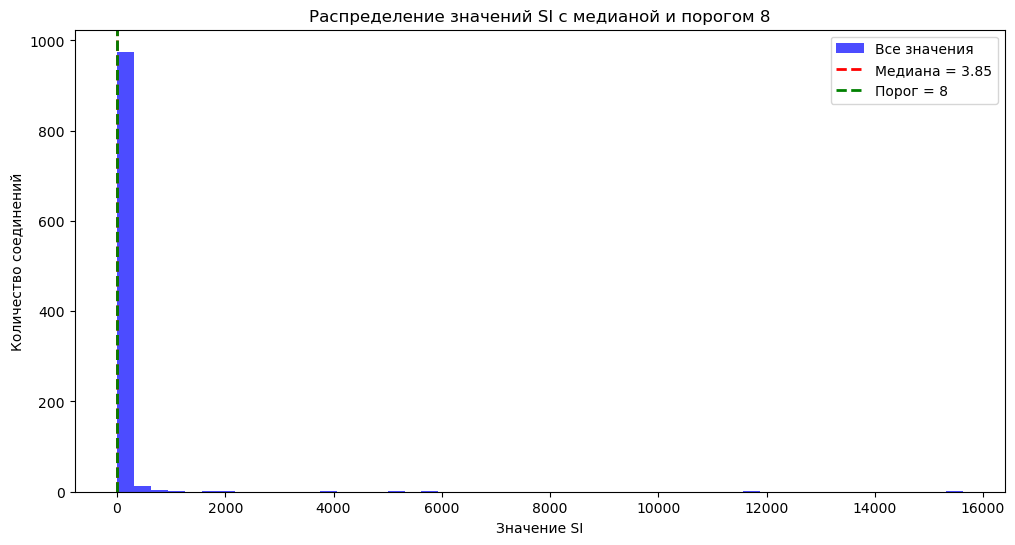


Обучение моделей для классификации: SI > 8

=== Модели для классификации: SI_above_8 ===

Обучение модели: Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       130
           1       0.56      0.44      0.49        71

    accuracy                           0.68       201
   macro avg       0.64      0.63      0.63       201
weighted avg       0.67      0.68      0.67       201

ROC-AUC: 0.6854

Обучение модели: Gradient Boosting
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       130
           1       0.65      0.42      0.51        71

    accuracy                           0.72       201
   macro avg       0.69      0.65      0.66       201
weighted avg       0.71      0.72      0.70       201

ROC-AUC: 0.7146

Обучение модели: XGBoost
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       130
           1   

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('cleaned_data.csv')

# Удаление ненужных столбцов
data = data.drop('Unnamed: 0', axis=1)

# Создание бинарных целевых переменных на основе медианных значений
median_si = data['SI'].median()
# 1. Добавляем пороговое значение и новую бинарную переменную
si_threshold = 8
data['SI_above_8'] = (data['SI'] > si_threshold).astype(int)

# 2. Анализ распределения относительно порога 8
print("\n" + "="*50)
print(f"Анализ значений SI относительно порога {si_threshold}:")
print(f"Медианное значение SI: {median_si:.4f}")
print(f"Количество соединений с SI > {si_threshold}: {data['SI_above_8'].sum()} из {len(data)}")
print(f"Доля соединений с SI > {si_threshold}: {data['SI_above_8'].mean():.2%}")
print("="*50 + "\n")

# 3. Визуализация распределения с обоими порогами
plt.figure(figsize=(12, 6))
plt.hist(data['SI'], bins=50, alpha=0.7, color='blue', label='Все значения')
plt.axvline(median_si, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_si:.2f}')
plt.axvline(si_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Порог = {si_threshold}')
plt.title('Распределение значений SI с медианой и порогом 8')
plt.xlabel('Значение SI')
plt.ylabel('Количество соединений')
plt.legend()
plt.show()

# 4. Обновляем targets для включения новой переменной
targets = data[['SI_above_8']]

# 5. Разделяем данные с учетом новой целевой переменной
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, targets, test_size=0.2, random_state=42)

# 6. Обучаем модели для нового порога
print("\n" + "="*50)
print("Обучение моделей для классификации: SI > 8")
print("="*50)
si8_results, si8_best = train_and_evaluate_models(X_train, X_test, y_train, y_test, 'SI_above_8')

# 7. Оптимизация лучшей модели для нового порога
best_si8_model = optimize_best_model(si8_best, X_train, y_train['SI_above_8'])

# 8. Функция для интерпретации результатов (добавьте в код)
def interpret_results(model, X_test, y_test, threshold_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    results_df = pd.DataFrame({
        'True_Value': y_test.values.flatten(),
        'Predicted_Probability': y_proba
    })
    
    print(f"\nАнализ ошибок для {threshold_name}:")
    print(f"Точность на тестовой выборке: {np.mean(results_df['True_Value'] == (results_df['Predicted_Probability'] > 0.5).astype(int)):.2%}")
    print(f"Средняя вероятность для положительного класса: {results_df[results_df['True_Value'] == 1]['Predicted_Probability'].mean():.2%}")
    print(f"Средняя вероятность для отрицательного класса: {results_df[results_df['True_Value'] == 0]['Predicted_Probability'].mean():.2%}")
    
    return results_df

# 9. Интерпретация результатов для обоих порогов
si_8_results = interpret_results(best_si8_model, X_test, y_test['SI_above_8'], 'SI > 8')